In [ ]:
import pandas as pd
from pathlib import Path


def swap(original, replacement, class_name):
    orig = Path(original)
    repl = Path(replacement)
    print(f"Updating {orig} with {class_name} detections from {repl}...")
    df = pd.read_csv(orig)
    new_detections = pd.read_csv(repl)

    keep = df[df["class_name"] != class_name]
    updated = (
        pd.concat([keep, new_detections], ignore_index=True)
        .sort_values(["file_name", "frame_index", "detection_index"])
        .reset_index(drop=True)
    )

    backup = orig.with_suffix(orig.suffix + ".bak")
    orig.rename(backup)
    updated.to_csv(orig, index=False)
    print(f"  wrote {len(updated):,} rows (backup saved to {backup})")


swap("data/train_object_detections.csv", "data/ball_trackingv4_train.csv", "baseball")
swap("data/test_object_detections.csv", "data/ball_trackingv4_test.csv", "baseball")
swap("data/train_object_detections.csv", "data/train_homeplate.csv", "homeplate")
swap("data/test_object_detections.csv", "data/test_homeplate.csv", "homeplate")

Updating data/train_object_detections.csv with baseball detections from data/ball_trackingv4_train.csv...
  wrote 356,757 rows (backup saved to data/train_object_detections.csv.bak)
Updating data/test_object_detections.csv with baseball detections from data/ball_trackingv4_test.csv...
  wrote 238,214 rows (backup saved to data/test_object_detections.csv.bak)


# Tabular Classifier

Pitch prediction - LGBMClassifier
Zone prediction - random forest


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from ml_features import FeaturePipeline, INV_PITCH_MAP, PITCH_MAP
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score

# 0. Load data
train_path = "data/train_ground_truth.csv"
test_path = "data/test_features.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# 1. Feature extraction
pipeline = FeaturePipeline()
pipeline.fit(train_df, test_df)
train_features = pipeline.transform(train_df)
test_features = pipeline.transform(test_df)

# 2. Model training
pitch_labels = train_df["pitch_class"]
zone_labels = train_df["zone"]

pitch_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
zone_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pitch_estimator = CatBoostClassifier(
    iterations=100,
    learning_rate=1,
)

pitch_estimator.fit(train_features, pitch_labels)


# 3. Model evaluation
scores = cross_val_score(
    pitch_estimator, train_features, pitch_labels, cv=pitch_cv, scoring="accuracy"
)
print(f"Pitch accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")


# 4. Model prediction
pitch_predictions = pitch_estimator.predict(test_features)

# 5. Model evaluation
submission = pd.DataFrame(
    {
        "file_name": test_df["file_name"],
        "pitch_class": pitch_predictions,
    }
)

submission["pitch_class"].value_counts()

0:	learn: 0.6880085	total: 60.6ms	remaining: 6s
1:	learn: 0.6848286	total: 61.8ms	remaining: 3.03s
2:	learn: 0.6813403	total: 62.6ms	remaining: 2.02s
3:	learn: 0.6771423	total: 63.7ms	remaining: 1.53s
4:	learn: 0.6751957	total: 64.6ms	remaining: 1.23s
5:	learn: 0.6704801	total: 65.3ms	remaining: 1.02s
6:	learn: 0.6679272	total: 66.1ms	remaining: 878ms
7:	learn: 0.6630420	total: 66.9ms	remaining: 769ms
8:	learn: 0.6589281	total: 67.6ms	remaining: 684ms
9:	learn: 0.6556852	total: 68.7ms	remaining: 618ms
10:	learn: 0.6525542	total: 69.7ms	remaining: 564ms
11:	learn: 0.6491694	total: 70.7ms	remaining: 518ms
12:	learn: 0.6449198	total: 71.4ms	remaining: 478ms
13:	learn: 0.6421345	total: 72.2ms	remaining: 443ms
14:	learn: 0.6384728	total: 73ms	remaining: 413ms
15:	learn: 0.6322883	total: 73.7ms	remaining: 387ms
16:	learn: 0.6278677	total: 74.4ms	remaining: 363ms
17:	learn: 0.6256015	total: 75.1ms	remaining: 342ms
18:	learn: 0.6217495	total: 75.9ms	remaining: 324ms
19:	learn: 0.6186859	total:

pitch_class
strike    2000
ball      2000
Name: count, dtype: int64

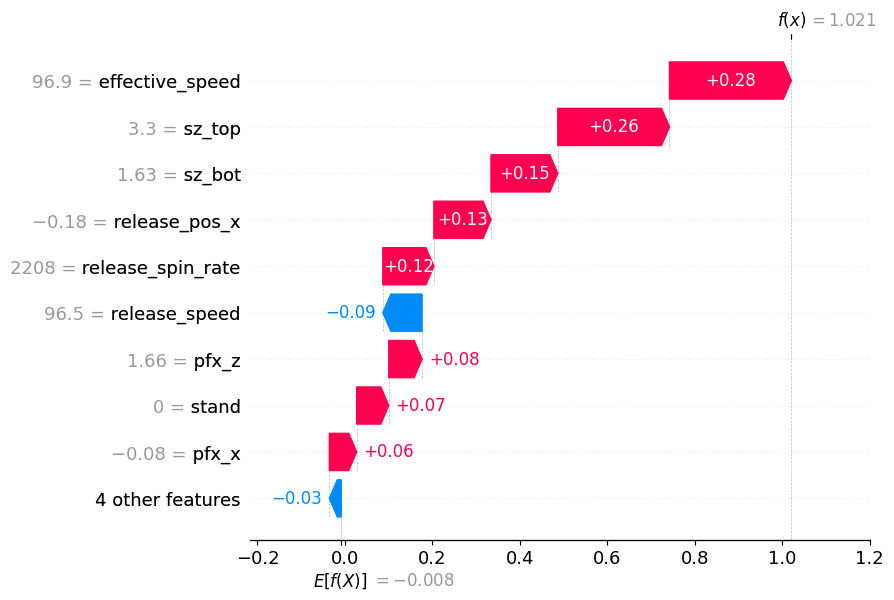

In [3]:
import shap

explainer = shap.Explainer(pitch_estimator)
shap_values = explainer(test_features)
shap.plots.waterfall(shap_values[0])

In [ ]:
from baseballcv.functions import LoadTools
from baseballcv.model import Florence2, PaliGemma2, YOLOv9, DETR, RFDETR
from ultralytics import YOLO


def select_appropriate_model(use_case: str):
    """
    Choose the appropriate model based on use case requirements.
    """
    load_tools = LoadTools()

    if use_case == "real_time_ball_tracking":
        # YOLO for fast ball tracking
        return YOLO(load_tools.load_model("ball_trackingv4"))

    elif use_case == "advanced_ball_tracking":
        # YOLOv9 for improved accuracy and performance
        return YOLOv9(device="cuda", name="yolov9-c")

    elif use_case == "player_detection":
        # DETR for precise player detection
        return DETR(num_labels=4, device="cuda")

    elif use_case == "glove_tracking":
        # RFDETR for specialized glove tracking
        return RFDETR(device="cuda", labels=["glove", "homeplate", "baseball"])

    elif use_case == "scene_understanding":
        # Florence2 for contextual understanding
        return Florence2()

    elif use_case == "natural_language_queries":
        # PaliGemma2 for complex queries
        return PaliGemma2()

In [15]:
from pathlib import Path
import torch.serialization
from baseballcv.functions import LoadTools
from ultralytics import YOLO

video_path = Path("data/train_trimmed/pitch3.mp4")

load_tools = LoadTools()
model = YOLO(load_tools.load_model("ball_trackingv4"))
results = model.predict(source=str(video_path), save=True, conf=0.10)

# inspect results[0].boxes.xyxy, etc., or save annotated frames:
# model.save_dir  # where Ultralytics stored the run outputs
results[0]

2025-11-20 22:14:44,530 - LoadTools - INFO - Model found at models/od/YOLO/ball_tracking/model_weights/ball_trackingv4.pt

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/18) /Users/yifanwu/Desktop/VIDA/Computer Vision/baseball-pitch-prediction/data/train_trimmed/pitch3.mp4: 384x640 1 baseball, 362.8ms
video 1/1 (frame 2/18) /Users/yifanwu/Desktop/VIDA/Computer Vision/baseball-pitch-prediction/data/train_trimmed/pitch3.mp4: 384x640 1 baseball, 330.7ms
video 1/1 (frame 3/18) /Users/

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'glove', 1: 'homeplate', 2: 'baseball', 3: 'rubber'}
obb: None
orig_img: array([[[ 46,  39,  26],
        [ 46,  39,  26],
        [ 46,  39,  26],
        ...,
        [ 48,  37,  28],
        [ 48,  37,  28],
        [ 52,  40,  32]],

       [[ 46,  39,  26],
        [ 46,  39,  26],
        [ 46,  39,  26],
        ...,
        [ 48,  37,  28],
        [ 48,  37,  28],
        [ 52,  40,  32]],

       [[ 46,  39,  26],
        [ 46,  39,  26],
        [ 46,  39,  26],
        ...,
        [ 48,  37,  28],
        [ 48,  37,  28],
        [ 52,  40,  32]],

       ...,

       [[ 74, 127,  98],
        [ 74, 127,  98],
        [ 74, 127,  98],
        ...,
        [ 83, 130, 105],
        [ 86, 132, 108],
        [ 87, 133, 109]],

       [[ 72, 125,  96],
        [ 72, 125,  96],
        [ 72, 125,  96],
        ...,
        [ 81, 127, 1

In [16]:
for r in results:
    for box in r.boxes.cpu().numpy():
        print(f"XYXY: {box.xyxy}")
        print(f"XYWHN (Normalized XYWH): {box.xywh}")
        print(f"XYXYN (Normalized XYXY): {box.xyxyn}")
        print(f"Confidence: {box.conf}")
        print(f"Track ID: {box.id}")
        print(f"Class Value: {box.cls} \n")

XYXY: [[      514.9      367.38      533.98      384.18]]
XYWHN (Normalized XYWH): [[     524.44      375.78      19.076      16.804]]
XYXYN (Normalized XYXY): [[    0.40227     0.51024     0.41717     0.53358]]
Confidence: [    0.25204]
Track ID: None
Class Value: [          2] 

XYXY: [[     456.59      380.16      476.96       398.5]]
XYWHN (Normalized XYWH): [[     466.78      389.33      20.368       18.34]]
XYXYN (Normalized XYXY): [[    0.35671       0.528     0.37262     0.55347]]
Confidence: [    0.45751]
Track ID: None
Class Value: [          2] 

XYXY: [[     452.21      370.65      487.46      390.98]]
XYWHN (Normalized XYWH): [[     469.83      380.81      35.252      20.321]]
XYXYN (Normalized XYXY): [[    0.35329      0.5148     0.38083     0.54302]]
Confidence: [     0.3401]
Track ID: None
Class Value: [          2] 

XYXY: [[     438.09      348.42       457.7      365.34]]
XYWHN (Normalized XYWH): [[      447.9      356.88      19.604       16.92]]
XYXYN (Normalized X